# Synthetic contours

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from helpers import cm2inch, title

from src.dataset import Dataset
from src.preprocess.synthesize import MarkovSynthesizer
from src.preprocess.synthesize import BinomialWalkSynthesizer

## Markov contour synthesizer

In [2]:
# Load dataset and fit markov synthesizer
dataset = Dataset('combined-phrase')
contours = dataset.contours('pitch')
markov_synthesizer = MarkovSynthesizer()
markov_synthesizer.fit(contours, dataset.df['unit_length'])

binom_synthesizer = BinomialWalkSynthesizer()
binom_synthesizer.fit(dataset.df['unit_length'])

### Initial distribution

/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'density')

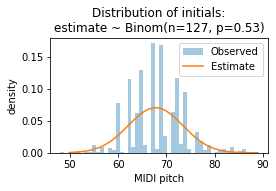

In [3]:
# Plot initial distribution
plt.subplots(1, figsize=cm2inch(10, 7), tight_layout=True)
I = markov_synthesizer.initial_distr
sns.distplot(contours[:, 0], kde=False, norm_hist=True, label='Observed')
xs = np.arange(50, 90)
plt.plot(xs, I.pmf(xs), label=f'Estimate')
plt.legend()
plt.title(
    f'Distribution of initials:\n'
    f'estimate ~ Binom(n={I.kwds["n"]}, p={I.kwds["p"]:.2f})'
)
plt.xlabel('MIDI pitch')
plt.ylabel('density')

### Transition matrix

Text(0.5, 1.0, 'Transition probabilities')

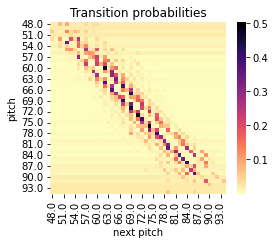

In [4]:
plt.figure(figsize=cm2inch(10, 8))
sns.heatmap(markov_synthesizer.transition_matrix, cmap='magma_r')
plt.xlabel('next pitch')
plt.ylabel('pitch')
plt.title('Transition probabilities')

## Visualize synthetic contours

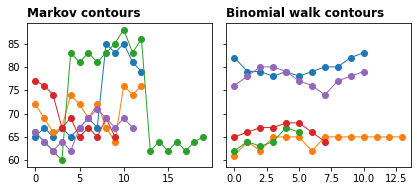

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=cm2inch(15, 7), sharey=True, tight_layout=True)

for i in range(5):
    ax0.plot(markov_synthesizer.generate(), 'o-', lw=1)
title('Markov contours', ax=ax0)

for i in range(5):
    ax1.plot(binom_synthesizer.generate(), 'o-', lw=1)
title('Binomial walk contours', ax=ax1)

In [6]:
markov_contours = Dataset('markov').representation('pitch', limit=500)
binom_contours = Dataset('binom').representation('pitch', limit=500)

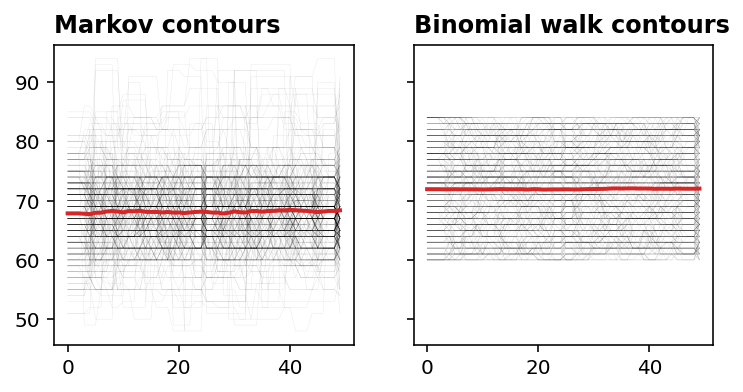

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=cm2inch(15, 7))

ax0.plot(markov_contours.T, 'k-', lw=.2, alpha=.1)
ax0.plot(markov_contours.mean(axis=0), 'C3', lw=2)
title('Markov contours', ax=ax0)

ax1.plot(binom_contours.T, 'k-', lw=.2, alpha=.1)
ax1.plot(binom_contours.mean(axis=0), 'C3', lw=2)
title('Binomial walk contours', ax=ax1)

## Cluster synthetic contours

In [2]:
import umap
import umap.plot
from scipy.fft import idct
from src.preprocess.synthesize import subsample_clustered_contours

In [75]:
markov = Dataset('markov')
markov_contours = markov.contours('pitch', limit=5000)
markov_cosine = markov.contours('cosine', limit=5000)
markov_cosine[:, 25:] = 0
_, labels, indices, centers = subsample_clustered_contours(
    markov_cosine, k=5, cluster_size=200)
clustered_contours = markov_contours[indices, :]

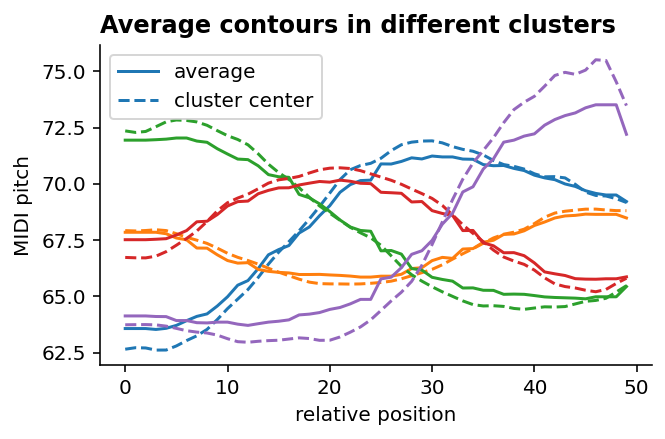

In [79]:
plt.subplots(figsize=cm2inch(12, 8), tight_layout=True)
for i in range(len(set(labels))):
    avg_contour = clustered_contours[labels == i].mean(axis=0)
    plt.plot(avg_contour,  c=f'C{i}',
        label='average' if i==0 else None)
    plt.plot(idct(centers[i]) + avg_contour.mean(), '--', c=f'C{i}',
        label='cluster center' if i==0 else None)
plt.legend()
plt.xlabel('relative position')
plt.ylabel('MIDI pitch')
title('Average contours in different clusters')
sns.despine()

This is where the clusters end up in the dataset they were originally sampled from:

In [80]:
mapper = umap.UMAP(random_state=0).fit(markov_contours)

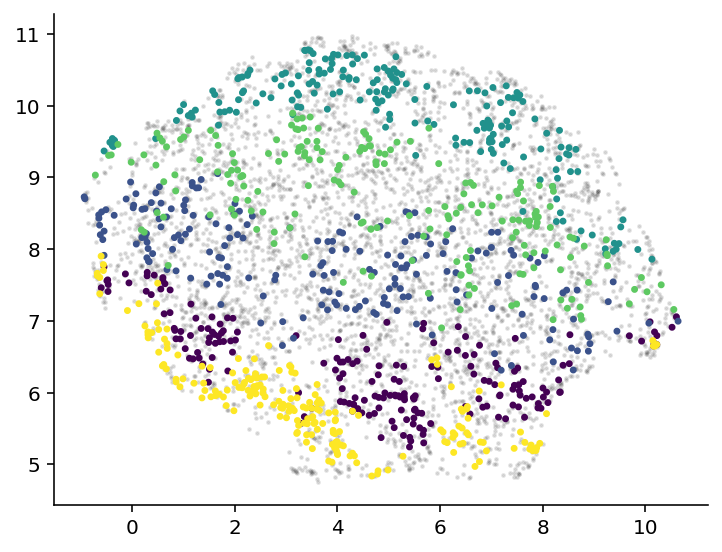

In [82]:
plt.subplots(figsize=cm2inch(13, 10), tight_layout=True)
other_idx = np.setdiff1d(np.arange(len(markov_contours)), indices)
x, y = mapper.embedding_[other_idx].T
plt.scatter(x, y, c='k', alpha=.1, s=2)

x, y = mapper.embedding_[indices].T
plt.scatter(x, y, c=labels, s=6, alpha=1)
sns.despine()

## Clustered dataset

And finally a look at the actual dataset

In [2]:
clustered = Dataset('clustered', refresh=True)
clustered_contours = clustered.contours('pitch', limit=3000)
labels = clustered.subset_column('label', limit=3000)

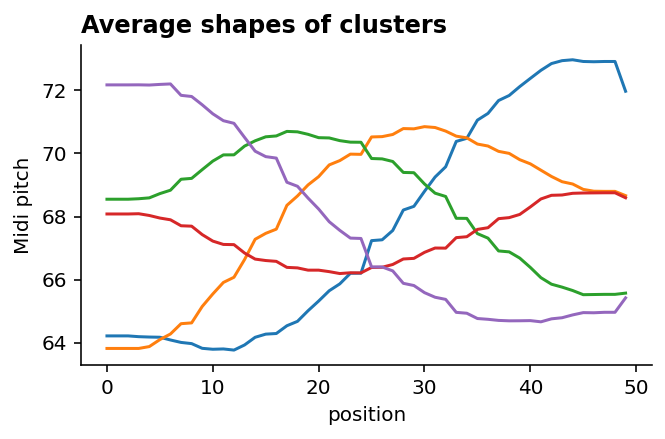

In [3]:
plt.subplots(figsize=cm2inch(12, 8), tight_layout=True)
for i in range(5):
    plt.plot(clustered_contours[labels==i].mean(axis=0))
title('Average shapes of clusters')
plt.xlabel('position')
plt.ylabel('Midi pitch')
sns.despine()

In [93]:
pitch_mapper = umap.UMAP(random_state=0).fit(
    clustered.contours('pitch', limit=3000)
)
centered_mapper = umap.UMAP(random_state=0).fit(
    clustered.contours('pitch_centered', limit=3000)
)
cosine_mapper = umap.UMAP(random_state=0).fit(
    clustered.contours('cosine', limit=3000)
)

<AxesSubplot:title={'center':'Cosine'}>

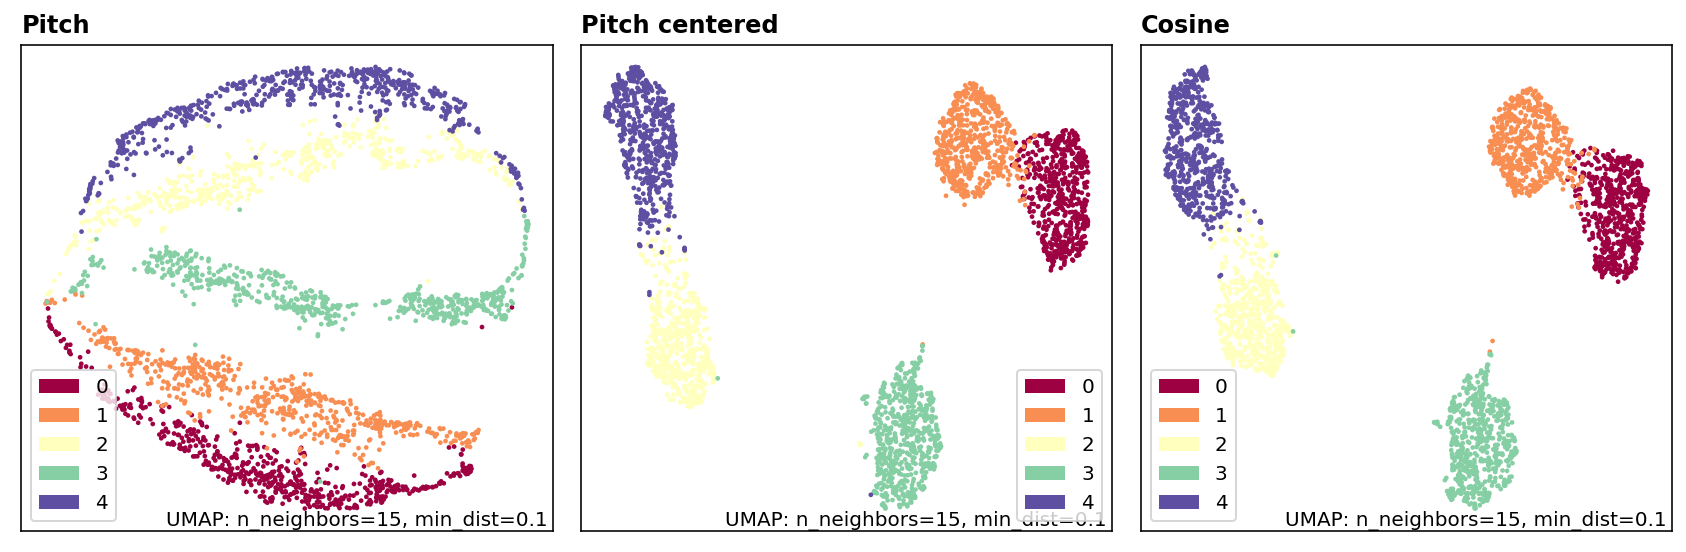

In [96]:
cm = 1/2.54 
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30*cm, 10*cm), tight_layout=True)

title('Pitch', ax=ax0)
umap.plot.points(pitch_mapper, labels, ax=ax0)

title('Pitch centered', ax=ax1)
umap.plot.points(centered_mapper, labels, ax=ax1)

title('Cosine', ax=ax2)
umap.plot.points(cosine_mapper, labels, ax=ax2)

In [4]:
from tableone.modality import hartigan_diptest
from src.condition import Condition
from src.config import ALL_REPRESENTATIONS

/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/tslearn/utils/utils.py:156: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; 

In [6]:
for repres in ALL_REPRESENTATIONS:
    try:
        condition = Condition('clustered', repres, 'dtw', unique=False, length=None)
        print(repres, condition.tableone_dist_dip_test())
    except: pass

pitch {'dip': 0.0008603278530024822, 'p': 0.8601487447126761}
pitch_centered {'dip': 0.0005009435493300574, 'p': 0.9994498273166658}
pitch_normalized {'dip': 0.0006036902711580305, 'p': 0.9944861922684699}
pitch_finalized {'dip': 0.0008327152418052819, 'p': 0.898778413556299}
interval {'dip': 0.009137028875065317, 'p': 0}
smooth_derivative {'dip': 0.0003517835685656334, 'p': 1}


In [21]:
condition = Condition('clustered', 'pitch', 'umap', unique=False, length=None)
condition.tableone_dist_dip_test()

{'dip': 0.008631537445682458, 'p': 0}

## Other stuff

In [2]:
import umap
from scipy.spatial.distance import pdist, squareform
from unidip.dip import diptst
from src.condition import Condition

In [3]:
def show_condition(condition):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
    plt.sca(axs[0])
    x, y = condition.umap_2d_embeddings().T
    plt.scatter(x, y, s=3, cmap='Set1',
        c=condition.df['label'] if 'label' in condition.df else None
    )
    title('UMAP')

    plt.sca(axs[1])
    sns.histplot(condition.similarities_sample(), ax=axs[1], kde=True, bins=100, lw=0, stat='density')
    plt.xlabel('Similarity')
    dip_test = condition.tableone_dist_dip_test()
    title(f'Similarity distribution ($p={dip_test["p"]:.4f}$)')
    sns.despine()

/Users/Bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


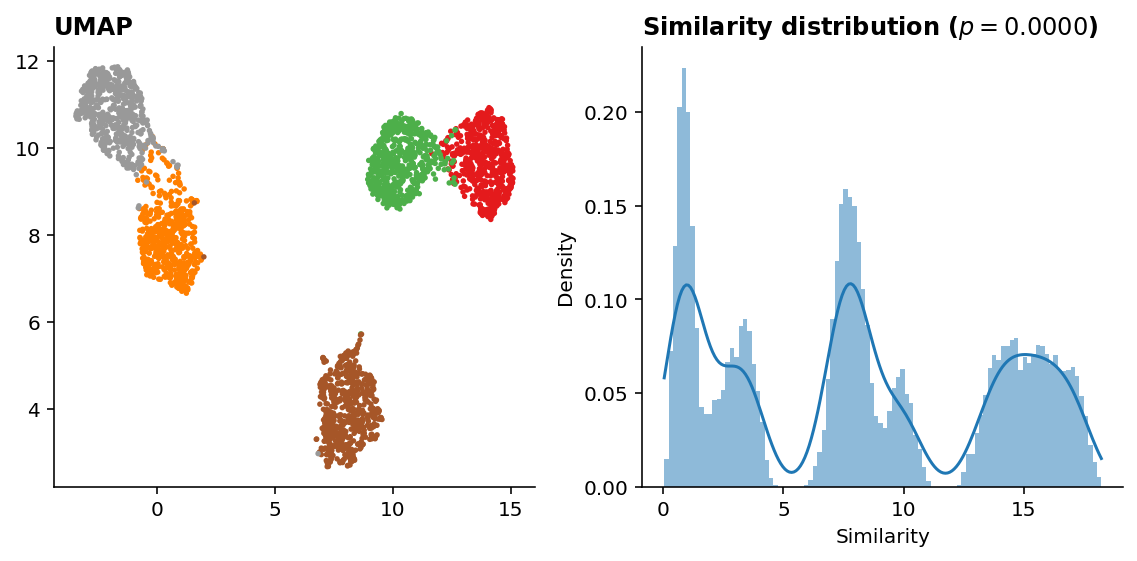

In [4]:
condition = Condition('clustered', 'pitch_centered', 'umap', 
    unique=False, length=None, limit=3000)
show_condition(condition)

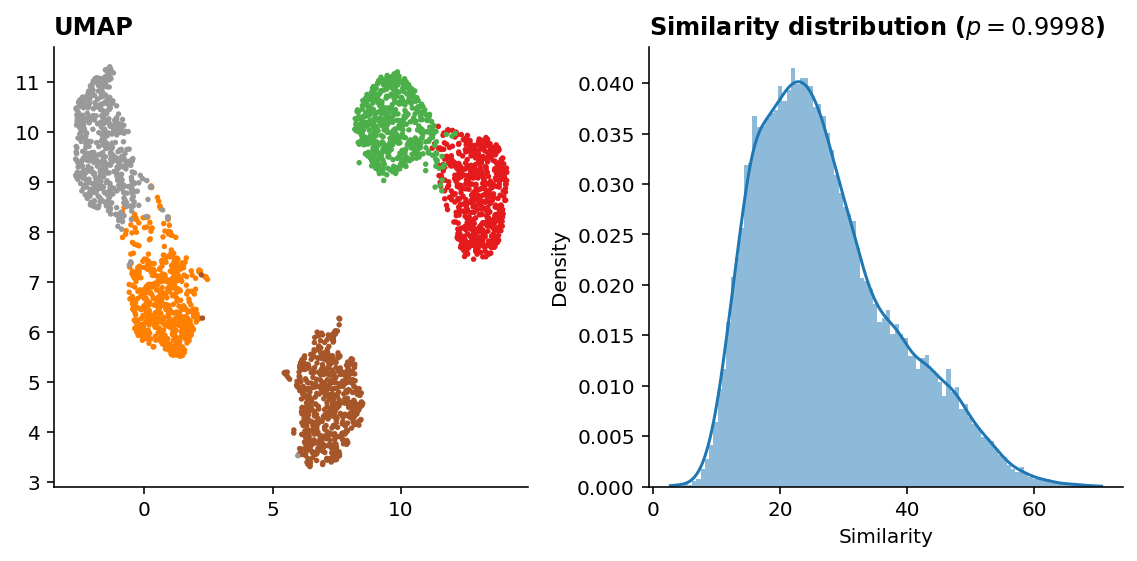

In [5]:
condition = Condition('clustered', 'pitch_centered', 'eucl', 
    unique=False, length=None, limit=3000)
show_condition(condition)

In [7]:
import diptest
from src.condition import tableone_dist_dip_test
from unidip.dip import diptst

In [6]:
condition = Condition('clustered', 'pitch_centered', 'eucl', 
    unique=False, length=None, limit=3000)

In [15]:
sims = condition.similarities_sample()

In [13]:
from scipy.stats import gaussian_kde

In [23]:
%timeit condition.dist_dip_test()

1.18 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%timeit condition.kde_similarities(refresh_memoized=True, refresh_serialized=True)

676 ms ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
condition.tableone_dist_dip_test()

{'dip': 0.000986463279460295, 'p': 0.9998484680792302}

In [8]:
condition.dist_dip_test()

(0.000986463279459997, 0.9998484680792371)

In [9]:
condition.dist_dip_test_bootstrap()

(0.000986463279459997, 1.0)

In [10]:
dip, pval = diptest.diptest(sims, boot_pval=True, n_boot=5000)
dip, pval

(0.000986463279459997, 1.0)

In [11]:
dip, pval = diptest.diptest(sims)
dip, pval

(0.000986463279459997, 0.9998484680792371)

In [12]:
condition.tableone_dist_dip_test()

{'dip': 0.0002444060990594299, 'p': 0.08147203792283475}

In [17]:
condition.tableone_dist_dip_test(refresh_memoized=True, refresh_serialized=True)

{'dip': 0.000986463279460295, 'p': 0.9998484680792302}

In [13]:
tableone_dist_dip_test(sims)

{'dip': 0.000986463279460295, 'p': 0.9998484680792302}

In [14]:
condition.unidip_dist_dip_test()

nan

In [15]:
diptst(sims)
# dip = 0.0009864632794599898
# p = 1

/Users/Bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/unidip/dip.py:27: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (work_cdf[1:] - work_cdf[0]) / distances
/Users/Bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/unidip/dip.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.less(d, unif_dips).sum() + 1) / (np.float(numt) + 1)


(0.0009864632794599898, 1.0, (9682, 10050))

/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/unidip/dip.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.less(d, unif_dips).sum() + 1) / (np.float(numt) + 1)


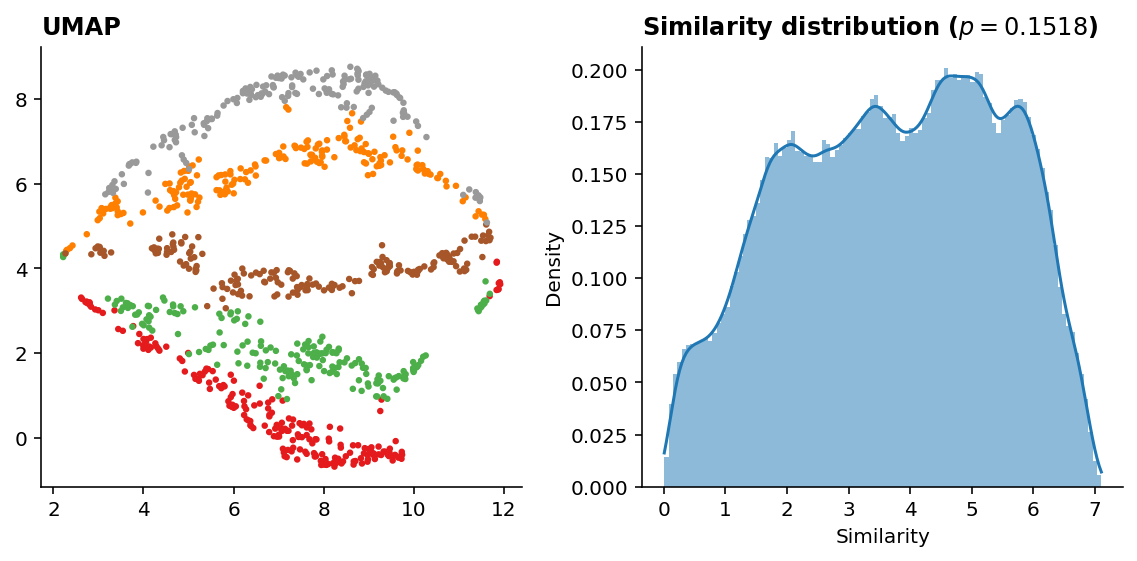

In [58]:
# condition = Condition('clustered', 'pitch', 'umap', 
#     unique=False, length=None, limit=1000)
# show_condition(condition)

/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/unidip/dip.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.less(d, unif_dips).sum() + 1) / (np.float(numt) + 1)


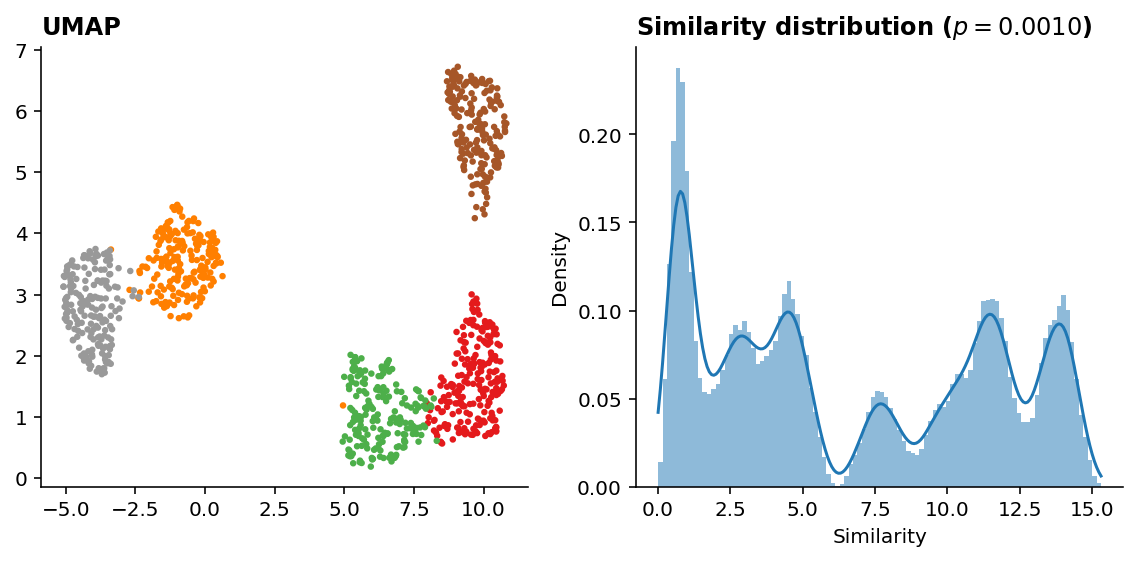

In [59]:
condition = Condition('clustered', 'cosine', 'umap', 
    unique=False, length=None, limit=1000)
show_condition(condition)

/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/unidip/dip.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.less(d, unif_dips).sum() + 1) / (np.float(numt) + 1)


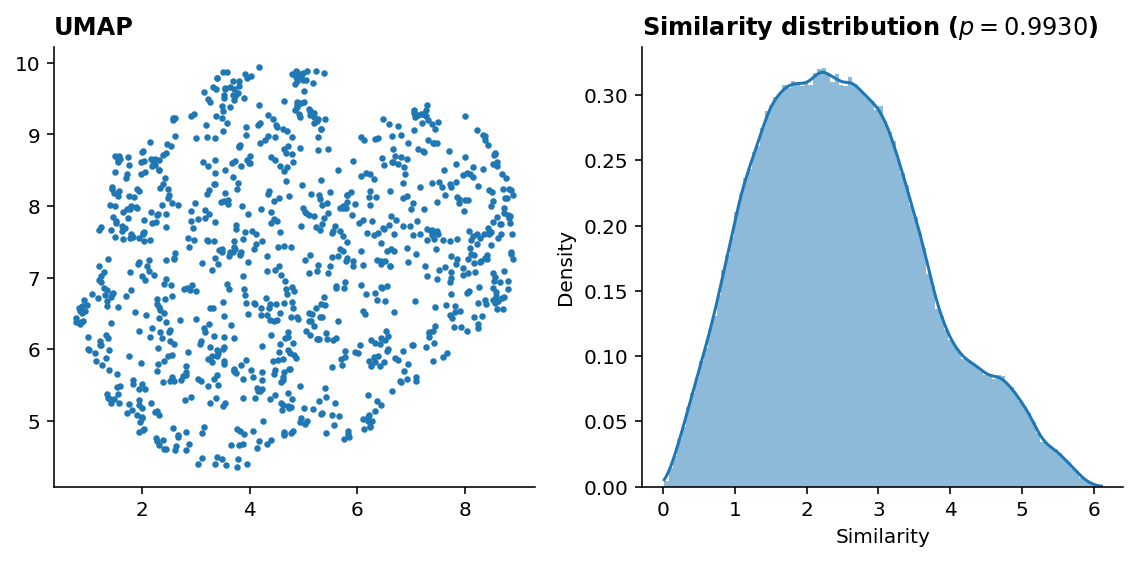

In [60]:
condition = Condition('markov', 'pitch_centered', 'umap', 
    unique=False, length=None, limit=1000)
show_condition(condition)

# PCA

We visualize the principal components of the Markov contours; these should correspond to cosine functions.

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
markov_contours = Dataset('markov').contours('pitch')
pca.fit(markov_contours)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'PCA components of synthetic Markov contours')

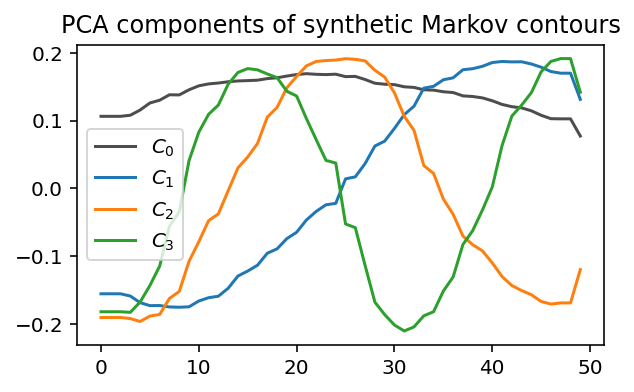

In [38]:
plt.figure(figsize=cm2inch(12,7))
plt.plot(pca.components_[0], '0.3', label='$C_0$')
plt.plot(pca.components_[1], 'C0', label='$C_1$')
plt.plot(pca.components_[2], 'C1', label='$C_2$')
plt.plot(pca.components_[3], 'C2', label='$C_3$')
plt.legend()
plt.title('PCA components of synthetic Markov contours')